In [3]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np

import torch
import torchvision
import torchvision.transforms as transforms
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

device = torch.device('mps')

In [4]:
# training
train_transform = transforms.Compose([
    transforms.RandomHorizontalFlip(), #ランダムに水平に反転
    transforms.ColorJitter(), #ランダムに色を変更
    transforms.RandomRotation(10), #ランダムに回転
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
    ])
trainset = torchvision.datasets.CIFAR10(root='../data', train=True, download=True, transform=train_transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=64, shuffle=True, num_workers=2)

# test
test_transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
    ])
testset = torchvision.datasets.CIFAR10(root='../data', train=False, download=True, transform=test_transform)
testloader = torch.utils.data.DataLoader(testset, batch_size=64, shuffle=True, num_workers=2)

Files already downloaded and verified
Files already downloaded and verified


In [3]:
print('train: ', trainset.data.shape)
print('test: ', testset.data.shape)

train:  (50000, 32, 32, 3)
test:  (10000, 32, 32, 3)


In [4]:
classes = trainset.classes
print(classes)

['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']


<class 'torch.Tensor'>
<class 'numpy.ndarray'>
(3, 274, 274)
(274, 274, 3)


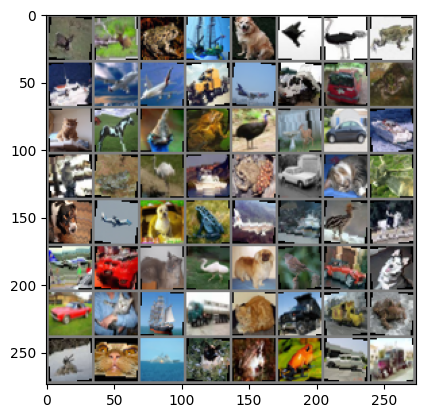

In [6]:
def imshow(img):
    img = img / 2 + 0.5
    print(type(img))
    npimg = img.numpy()
    print(type(npimg))
    print(npimg.shape)
    npimg = np.transpose(npimg, (1, 2, 0))
    print(npimg.shape)
    plt.imshow(npimg)
    plt.show()

dataiter = iter(trainloader)
images, labels = next(dataiter)
imshow(torchvision.utils.make_grid(images))

In [8]:
class CNN(nn.Module):
    def __init__(self, num_classes=10):
        super().__init__()
        self.features = nn.Sequential(
            nn.Conv2d(in_channels=3, out_channels=64, kernel_size=5, padding=2),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2),
            nn.Conv2d(in_channels=64, out_channels=128, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2),
            nn.Conv2d(in_channels=128, out_channels=256, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2),
            nn.Conv2d(in_channels=256, out_channels=128, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
        )
        self.classifier = nn.Linear(in_features=4 * 4 * 128, out_features=num_classes)

    def forward(self, x):
        x = self.features(x)
        x = x.view(x.size(0), -1)
        x = self.classifier(x)
        return x

model = CNN()
model.to(device)

CNN(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (1): ReLU(inplace=True)
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (4): ReLU(inplace=True)
    (5): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (6): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (7): ReLU(inplace=True)
    (8): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (9): Conv2d(256, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (10): ReLU(inplace=True)
  )
  (classifier): Linear(in_features=2048, out_features=10, bias=True)
)

In [9]:
# 損失関数: クロスエントロピー
criterion = nn.CrossEntropyLoss()
# 最適化関数: Adam
optimizer = optim.Adam(model.parameters(), lr=0.001, weight_decay=5e-4)

In [10]:
num_epochs = 15
losses = []
accs = []
val_losses = []
val_accs = []
for epoch in range(num_epochs):
    running_loss = 0.0
    running_acc = 0.0
    for imgs, labels in trainloader:
        imgs = imgs.to(device)
        labels = labels.to(device)
        optimizer.zero_grad()
        output = model(imgs)
        loss = criterion(output, labels)
        loss.backward()
        running_loss += loss.item()
        pred = torch.argmax(output, dim=1)
        running_acc += torch.mean(pred.eq(labels).float())
        optimizer.step()
    running_loss /= len(trainloader)
    running_acc /= len(trainloader)
    losses.append(running_loss)
    accs.append(running_acc)

    # test
    val_running_loss = 0.0
    val_running_acc = 0.0
    for val_imgs, val_labels in testloader:
        val_imgs = val_imgs.to(device)
        val_labels = val_labels.to(device)
        val_output = model(val_imgs)
        val_loss = criterion(val_output, val_labels)
        val_running_loss += val_loss.item()
        val_pred = torch.argmax(val_output, dim=1)
        val_running_acc += torch.mean(val_pred.eq(val_labels).float())
    val_running_loss /= len(testloader)
    val_running_acc /= len(testloader)
    val_losses.append(val_running_loss)
    val_accs.append(val_running_acc)
    print("epoch: {}, loss: {}, acc: {}, \
        val loss: {}, val acc: {}".format(epoch, running_loss, running_acc, val_running_loss, val_running_acc))

epoch: 0, loss: 1.453649642446157, acc: 0.47230657935142517,         val loss: 1.1444260413479652, val acc: 0.6029060482978821
epoch: 1, loss: 1.0296527334033985, acc: 0.6360294222831726,         val loss: 0.8913124146734833, val acc: 0.6776472926139832
epoch: 2, loss: 0.8585668216123605, acc: 0.7003875970840454,         val loss: 0.7915166882193012, val acc: 0.7275079488754272
epoch: 3, loss: 0.7657772226787894, acc: 0.7338355183601379,         val loss: 0.7540938916859353, val acc: 0.7402468323707581
epoch: 4, loss: 0.7014365973298812, acc: 0.756873369216919,         val loss: 0.6897100451265931, val acc: 0.7668192982673645
epoch: 5, loss: 0.6528490608000694, acc: 0.7725782990455627,         val loss: 0.6487365290997135, val acc: 0.7730891704559326
epoch: 6, loss: 0.6155368225729984, acc: 0.7854059934616089,         val loss: 0.6445628245165393, val acc: 0.7871218323707581
epoch: 7, loss: 0.588806859786858, acc: 0.7947370409965515,         val loss: 0.6028784274295637, val acc: 0.790

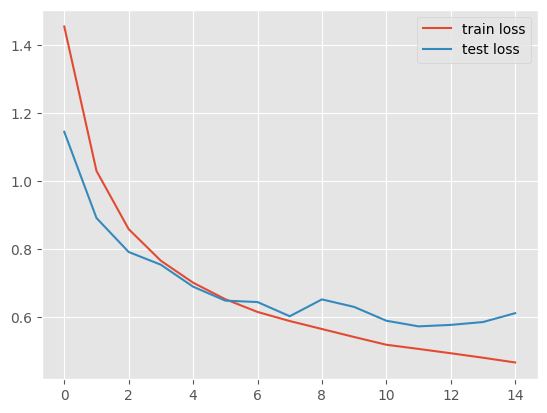

In [11]:
plt.style.use("ggplot")
plt.plot(losses, label="train loss")
plt.plot(val_losses, label="test loss")
plt.legend()

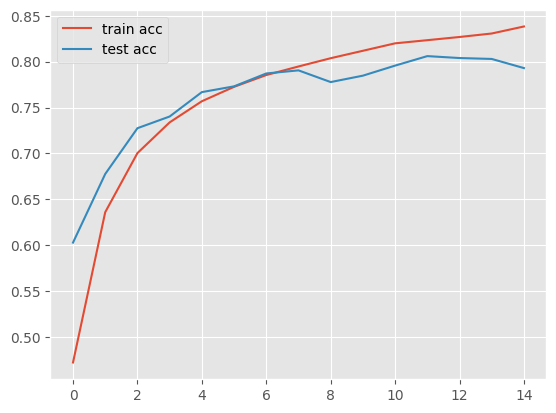

In [22]:
accs_array = [t.detach().cpu().numpy() for t in accs]
val_accs_array = [t.detach().cpu().numpy() for t in val_accs]
plt.plot(accs_array, label="train acc")
plt.plot(val_accs_array, label="test acc")
plt.legend()

In [23]:
PATH = '../models/cifar10.pth'
torch.save(model.state_dict(), PATH)